# Convolutional layer


**Task:** 

* **Given**

The function for the cross-correlation which is used in Conv-nets
$$P_{c,x,y} = b + \sum_{d = 0}^{D}\sum_{i = -\frac{k}{2}}^{\frac{k}{2}} \sum_{j = -\frac{k}{2}}^{\frac{k}{2}} w_{c,d,i,j}*X_{d,x+i,y+j}$$

Where c is the filter index of the output feature map vector, D is the number of feature-maps in the input and k is the size of the convolution kernel. $P_{c,x,y}$ is one pixel in one feature map c.

* **Find** 
    * The equations for backward pass in a convolutional net
    * A numerical forward pass that qualitatively seems reasonable
    * A numerical solution to a forward and backward pass in a convolutional net that proves the correctness of the gradients.
        * The solution should demonstrate how change of depth and height/width dimension is handled in a convolutional net. Both by strided convolution and by maxpool
        * The gradients should be verified with an appropriate method.
        * For simplicity the L2 loss function is **given** $$L2 = \frac{1}{N} \sum_{i = 0}^{N} \frac{1}{2} (\hat{y_i}-y_i)^2$$, $$\frac{\partial L2}{\partial \hat{y_i}} = \frac{1}{N}(\hat{y_i} - y_i)$$



**Solution:**

The derivative of a pixel in the output feature map, with respect to an input pixel X_{d, x+i,y+j} will the be this:

$$\frac{\partial P_{c,x,y}}{\partial X_{d,x + i,y + j}} =  w_{c,d,i,j}$$

given that i and j are within within the kernel size, else the derivative is zero. Thus, to backpropagate, one must calculate the derivative of every pixel, in every feature map of the output, with respect to every pixel in every feature map of the input.

The derivative of a pixel in the output feature map, with respect to the weights is:

$$\frac{\partial P_{c,x,y}}{\partial w_{c,d,i,j}} =  X_{d, x+i, y+j}$$

To get the full derivative of the weights one must sum over all pixels, in all output channels.

The derivative of the bias is of course simply 1.


When we have the derivatives of the Convolutional layer, we can use the chain rule to backpropagate the loss through several layers. This code will illustrate a convolutional network fully working with multiple feature maps, configurable stride and padding.


## Model definitions

The following model defines a convolutional network with batch sizes of 1, or in other words no batches at all only singular examples. The model allows for variable input dimension and output dimension, and allows strided convolutions for downsampling. The ReLU activation function is defined, but could easily be switched out with any other activation function.

I have chosen to only provide this numerical example in python/numpy and not hand-calculated, as doing image convolutions by hand is a very tedious process.

The code for the network is a bit larger than I would like for a simple illustrative example, but every code line seems to be necessary.

In [1]:
import numpy as np

### The convolutional layer
This convolutional layer class implements a forward pass and backpropegation. The class saves the input feature maps $X$ as cache during the forward pass, as it is needed for the backward pass as stated in the equations above.

The interesting parts of this class is the line that calculates the output size of a convolutional layer

$$W_y = \frac{W_x - K + 2 P_w}{Stride} + 1$$

, and the actual forward and backward passes that are contained within the for-loops.



The code is inspired by https://becominghuman.ai/back-propagation-in-convolutional-neural-networks-intuition-and-code-714ef1c38199, however several changes are made. This conv layer has added the functionality of padding, bias, more channels and strided convolution. It might be that adding these things reduces the simplicity of the example, but I believe the additional insight they provide outweigh the increased complexity of the example.

In [2]:
class convLayer():
    def __init__(self, kernelsize, inputDim, outDim, stride=1, pad=0):
        self.kernelsize = kernelsize
        self.stride = stride
        self.pad = pad
        self.in_channels = inputDim
        self.out_channels = outDim
        
        self.W = np.random.normal(0, 1, (outDim, inputDim, kernelsize, kernelsize))
        #self.bias = np.random.normal(0,1,(outDim))
        
        self.cache = None
        
        self.gradW = None
        #self.gradB = None

    def __call__(self, x: np.ndarray):
        (D, x_width, x_height) = x.shape
        x = np.pad(x, (((0,0),(self.pad, self.pad),(self.pad,self.pad))), 'constant')
        
        output_size = (x_width - self.kernelsize + 2*self.pad)//self.stride + 1
        
        output = np.zeros((self.out_channels, output_size, output_size))
        stride = self.stride
        
        '''
        The following loop performes the equation described above. Instead of looping over all input channels, 
        I apply vectorisation with numpy.
        '''
        for i in range(output.shape[1]):
            for j in range(output.shape[2]):
                x_slice = x[:,i*stride:i*stride+self.kernelsize, j*stride:j*stride + self.kernelsize]
                output[:,i,j] += np.sum(self.W * x_slice, (1,2,3))# + self.bias   
        self.cache = x
        return output
    
    def backward(self, delta):
        x = self.cache

        (C,H, W) = delta.shape
    
        dX = np.zeros(x.shape)
        dW = np.zeros(self.W.shape)
        #dB = np.sum(delta, axis = (1,2))
        stride = self.stride
        # Looping over all pixels in the output. For all pixels and all channels the derivative of this layer is
        # calculated according to the above equations, and multiplied with delta according to the chain rule.
        for h in range(H):
            for w in range(W):
                dx = self.W * delta[:,h,w].reshape(C,-1,1,1)
                dX[:,h*stride:h*stride+self.kernelsize, w*stride:w*stride+self.kernelsize] += np.sum(dx,axis=0)
                
                x_slice = x[:,h*stride:h*stride+self.kernelsize, w*stride:w*stride+self.kernelsize]
                dW +=  x_slice* delta[:,h,w].reshape(C,-1,1,1)
    
        self.gradW = dW
        #self.gradB = dB
        return dX[:,self.pad:-self.pad, self.pad:-self.pad]
                
        

### Max Pool

The following class implements max pooling. Max Pool is a common method for down sampling the image h/w dimensions. A 2x2 grid is slided over the image in strides of 2, picking out the max value at each 2x2 section.

The **gradient** will be 1 every place where the max values originate, and 0 elsewhere. Therefor, the code saves a "bed of nails" image as cache, which keeps memory of which indexes provided the max values. Backward pass is then simply multiplying the delta with each appropriate 2x2 grid.

In [3]:
class MaxPool():
    '''
    This function performs maxpooling with stride of 2 and kernel size 2.
    It saves a ''needle map'' consisting of ones where the maximum value was taken from, and zero elsewhere.
    The backprop is simply multiplying delta with the needle map.
    '''
    def __init__(self):
        self.cache = None
    def __call__(self, x):
        self.cache = np.zeros(x.shape)
        output = np.zeros((x.shape[0],(x.shape[1]+1)//2, (x.shape[2]+1)//2))
        for i in range(output.shape[1]):
            for j in range(output.shape[2]):
                x_slice = x[:,i*2:i*2+2, j*2:j*2+2]
                output[:,i,j] = np.amax(x_slice, axis=(1,2))
   
                idx_map = np.where(x_slice == output[:,i,j].reshape(-1,1,1),\
                                   np.ones((output.shape[0],2,2)), np.zeros((output.shape[0],2,2)))
                self.cache[:,i*2:i*2+2, j*2:j*2+2] = idx_map
        return output
    def backward(self, d):
        output = np.zeros(self.cache.shape)
        for i in range(d.shape[1]):
            for j in range(d.shape[2]):
                self.cache[:,i*2:i*2+2,j*2:j*2+2]*= d[:,i,j].reshape(-1,1,1)
        return self.cache
        

### Activation and cost function

In [4]:
class ReLU():
    def __init__(self):
        self.cache = None
    def __call__(self, x):
        y = np.maximum(x,0.)
        self.cache = y
        return y
    def backward(self,y):
        return np.where(self.cache >0, 1,0)*y



In [5]:
class l2_loss():
    '''
    For simplicity the l2_loss function is hard-coded for image shape of 28x28
    '''
    def __init__(self):
        self.cache = None
    def __call__(self, x, y):
        self.cache = (x-y)/784
        return np.sum(0.5*(x-y)**2)/784
    def backward(self):
        return self.cache


## The forward function
This code will demonstrate the forward function, with a couple of known kernel weights. Note that the convoluion is strided, and as expected, the output feature size is reduced.

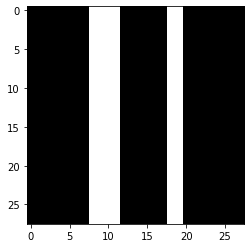

[[[[-1.      0.      1.    ]
   [-2.      0.      2.    ]
   [-1.      0.      1.    ]]]


 [[[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]]]


 [[[ 0.0625  0.125   0.0625]
   [ 0.125   0.25    0.125 ]
   [ 0.0625  0.125   0.0625]]]]
We can see that the result of the forward pass is as expected


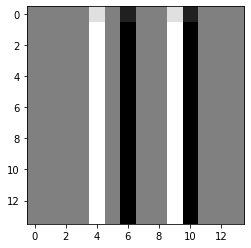

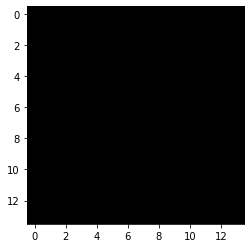

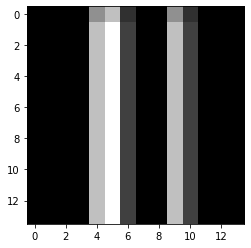

In [9]:
from matplotlib import pyplot as plt

#Defining our image
x = np.zeros((1,28,28))
x[0,:,18:20] = 1
x[0,:,8:12] = 1
plt.imshow(x[0], cmap = "gray")
plt.show()


#Defining our model
conv = convLayer(kernelsize = 3, inputDim=1, outDim=3, stride=2, pad=1)

#Sobel filter
conv.W[0] = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).reshape((1,3,3))
#Zero-weights
conv.W[1] = np.zeros((1,3,3))
#Gaussian blur
conv.W[2] = np.array([[1/16,2/16,1/16],[2/16,4/16,2/16],[1/16,2/16,1/16]]).reshape((1,3,3))
print(conv.W)

x = conv(x)

print("We can see that the result of the forward pass is as expected")
plt.imshow(x[0], cmap = "gray")
plt.show()
plt.imshow(x[1], cmap = "gray")
plt.show()
plt.imshow(x[2], cmap = "gray")
plt.show()

## Stacking layers together

As the layers has been defined abstract and modularized, we can build a network by stacking the moduels after each other. This code stacks 2 conv layers after one other followed by a maxpool layer, and checks the calculated gradient by comparing to finite differences. The activation function used is ReLU.

In [7]:
#Defining our model
conv1 = convLayer(kernelsize = 3, inputDim=1, outDim=3, stride=1, pad=1)
conv2 = convLayer(kernelsize = 3, inputDim=3, outDim=1, stride=2, pad=1)

maxpool = MaxPool()

rl1 = ReLU()
rl2 = ReLU()
l2 = l2_loss()

def model_forward(x):
    logits = conv1(x)
    logits = rl1(logits)
    logits = conv2(logits)
    logits = maxpool(logits)
    logits = rl2(logits)
    return logits

def model_backward():
    '''
    The backward function demonstrates the chain rule.
    The derivative delta is passed on layer by layer, to create an even longer
    chain as one gets deeper in the network.
    
    Using the delta notation, finding the derivatives in a deep net is no more difficult than
    in a shallow net.
    '''
    delta = l2.backward()
    
    delta = rl2.backward(delta)                
    delta = maxpool.backward(delta)
    
    delta = conv2.backward(delta)

    delta = rl1.backward(delta)
    delta = conv1.backward(delta)

#Defining our image
x = np.random.normal(0,1,(1,28,28))
#Our ''true'' downsampled image, that we will perform l2 norm-loss on
y = np.random.normal(0,1,(1,7,7))

## Gradient check
The following function performs a gradient check by comparing the calculated gradient with finite difference approximation. The result is of more interest than the details of the code, as it confirms that the backward pass in each model layer is correct.

In [8]:
#Performing gradient check
for l, layer in enumerate([conv1, conv2]):
    w_orig = layer.W.copy()
    epsilon = 1e-7
    for c in range(w_orig.shape[0]):
        for d in range(w_orig.shape[1]):
            print(f"Assessing convlayer: {l+1}, weights {c, d}" )
            for i in range(w_orig.shape[2]):
                for j in range(w_orig.shape[3]):
                    #Approximated gradient
                    orig = layer.W[c,d,i,j].copy()
                    layer.W[c,d,i,j] = orig + epsilon
                    logits = model_forward(x)
                    cost1 = l2(logits, y)
                    
                    layer.W[c,d,i,j] = orig - epsilon
                    logits = model_forward(x)
                    cost2 = l2(logits, y)
                    gradient_approximation = (cost1 - cost2) / (2 * epsilon)
                    
                    # Actual gradient
                    layer.W[c,d,i,j] = orig
                    #Forward
                    logits = model_forward(x)
                    loss = l2(logits,y)

                    #Backward
                    model_backward()
                    difference = gradient_approximation - layer.gradW[c, d, i, j]
                    assert abs(difference) <= epsilon,\
                        f"Calculated gradient is incorrect. " \
                        f"Approximation: {gradient_approximation}, actual gradient: {layer.gradW[c, d, i,j]}\n" \
                        f"The incorrect gradient was in c: {c},d: {d} i: {i}, j: {j}"
                    
                    
print("Finite differences and back-prop gradients agree. :)")

Assessing convlayer: 1, weights (0, 0)
Assessing convlayer: 1, weights (1, 0)
Assessing convlayer: 1, weights (2, 0)
Assessing convlayer: 2, weights (0, 0)
Assessing convlayer: 2, weights (0, 1)
Assessing convlayer: 2, weights (0, 2)
Finite differences and back-prop gradients agree. :)
